In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error as mae
from catboost import CatBoostRegressor

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("Road_noise_measurements.csv")

# Preprocessing

In [4]:
df = df.set_index(df['ID_MEASURING_RECORD'])
del df['ID_MEASURING_RECORD']

In [5]:
df['PERIOD_AND_TIME_SAMPLING'] = df['PERIOD_AND_TIME_SAMPLING'].str.replace('Day 12h', "3")
df['PERIOD_AND_TIME_SAMPLING'] = df['PERIOD_AND_TIME_SAMPLING'].str.replace('Evening 4h', "2")
df['PERIOD_AND_TIME_SAMPLING'] = df['PERIOD_AND_TIME_SAMPLING'].str.replace("Day 16h", "1")
df['PERIOD_AND_TIME_SAMPLING'] = df['PERIOD_AND_TIME_SAMPLING'].str.replace("Night 8h", "0")
df['PERIOD_AND_TIME_SAMPLING'] = df['PERIOD_AND_TIME_SAMPLING'].astype("int32")

In [6]:
encoder = LabelEncoder()
df['MEASURING_POINT_CODE'] = encoder.fit_transform(df['MEASURING_POINT_CODE'])

In [7]:
encoder = LabelEncoder()
df['TOWN'] = encoder.fit_transform(df['TOWN'])

In [8]:
del df['VOIVODESHIP']

In [9]:
df.head()

,TOWN,MEASURING_POINT_CODE,LATITUDE,LONGITUDE,DATE_MEASUREMENT_START,DATE_MEASUREMENT_END,PERIOD_AND_TIME_SAMPLING,AVG_NOISE_LVL
ID_MEASURING_RECORD,,,,,,,,
1,10,13,51.2558,15.5806,25/06/2018 11:53:00,16/10/2018 18:30:00,1,64.9
2,10,13,51.2558,15.5806,17/10/2018 22:00:00,18/10/2018 06:00:00,0,59.8
3,10,12,51.2534,15.5659,03/07/2018 09:21:00,09/10/2018 18:45:00,1,65.9
4,10,12,51.2534,15.5659,17/10/2018 22:00:00,18/10/2018 06:00:00,0,58.7
5,10,11,51.2649,15.5549,25/06/2018 09:59:00,18/10/2018 13:25:00,1,68.1


### Time cols preprocessing

In [10]:
df['MONTH_START'] = pd.to_datetime(df['DATE_MEASUREMENT_START']).dt.month
df['DAY_START'] = pd.to_datetime(df['DATE_MEASUREMENT_START']).dt.day
df['HOUR_START'] = pd.to_datetime(df['DATE_MEASUREMENT_START']).dt.hour
df['MINUTE_START'] = pd.to_datetime(df['DATE_MEASUREMENT_START']).dt.minute


df['MONTH_END'] = pd.to_datetime(df['DATE_MEASUREMENT_END']).dt.month
df['DAY_END'] = pd.to_datetime(df['DATE_MEASUREMENT_END']).dt.day
df['HOUR_END'] = pd.to_datetime(df['DATE_MEASUREMENT_END']).dt.hour
df['MINUTE_END'] = pd.to_datetime(df['DATE_MEASUREMENT_END']).dt.minute

del df['DATE_MEASUREMENT_START']
del df['DATE_MEASUREMENT_END']

# Clustering

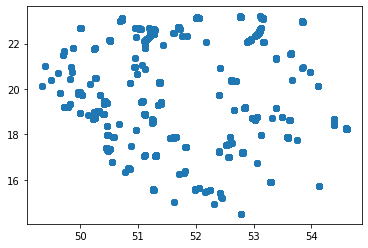

In [11]:
plt.scatter(df['LATITUDE'], df['LONGITUDE'])
plt.show()

Clusters:  5
Clusters:  7
Clusters:  9
Clusters:  11
Clusters:  13
Clusters:  15
Clusters:  17
Clusters:  19


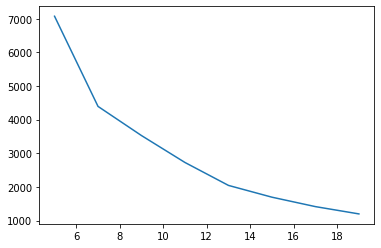

In [12]:
clust = df[["LATITUDE", "LONGITUDE"]]

results = []
for i in range(5, 21, 2):
    print("Clusters: ", i)
    model = KMeans(n_clusters=i)
    model.fit(clust)
    results.append(model.inertia_)

plt.plot(range(5, 21, 2), results)
plt.show()

In [13]:
n_clusters = 11

In [14]:
model = KMeans(n_clusters=n_clusters)
model.fit(clust)

KMeans(n_clusters=11)

In [15]:
df['Clust'] = model.predict(clust)

In [16]:
df.head()

,TOWN,MEASURING_POINT_CODE,LATITUDE,LONGITUDE,PERIOD_AND_TIME_SAMPLING,AVG_NOISE_LVL,MONTH_START,DAY_START,HOUR_START,MINUTE_START,MONTH_END,DAY_END,HOUR_END,MINUTE_END,Clust
ID_MEASURING_RECORD,,,,,,,,,,,,,,,
1,10,13,51.2558,15.5806,1,64.9,6,25,11,53,10,16,18,30,3
2,10,13,51.2558,15.5806,0,59.8,10,17,22,0,10,18,6,0,3
3,10,12,51.2534,15.5659,1,65.9,3,7,9,21,9,10,18,45,3
4,10,12,51.2534,15.5659,0,58.7,10,17,22,0,10,18,6,0,3
5,10,11,51.2649,15.5549,1,68.1,6,25,9,59,10,18,13,25,3


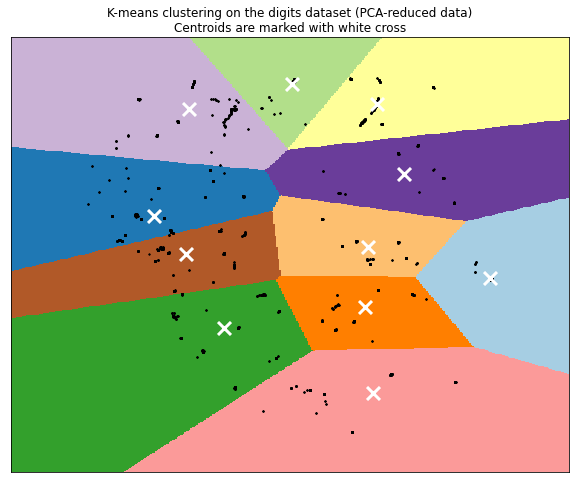

In [17]:
fig = plt.figure(figsize=[10, 8])

reduced_data  = np.array(clust)
kmeans = model

h = .02

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


In [18]:
df.head()

,TOWN,MEASURING_POINT_CODE,LATITUDE,LONGITUDE,PERIOD_AND_TIME_SAMPLING,AVG_NOISE_LVL,MONTH_START,DAY_START,HOUR_START,MINUTE_START,MONTH_END,DAY_END,HOUR_END,MINUTE_END,Clust
ID_MEASURING_RECORD,,,,,,,,,,,,,,,
1,10,13,51.2558,15.5806,1,64.9,6,25,11,53,10,16,18,30,3
2,10,13,51.2558,15.5806,0,59.8,10,17,22,0,10,18,6,0,3
3,10,12,51.2534,15.5659,1,65.9,3,7,9,21,9,10,18,45,3
4,10,12,51.2534,15.5659,0,58.7,10,17,22,0,10,18,6,0,3
5,10,11,51.2649,15.5549,1,68.1,6,25,9,59,10,18,13,25,3


In [19]:
df.dtypes

TOWN                          int32
MEASURING_POINT_CODE          int32
LATITUDE                    float64
LONGITUDE                   float64
PERIOD_AND_TIME_SAMPLING      int32
AVG_NOISE_LVL               float64
MONTH_START                   int64
DAY_START                     int64
HOUR_START                    int64
MINUTE_START                  int64
MONTH_END                     int64
DAY_END                       int64
HOUR_END                      int64
MINUTE_END                    int64
Clust                         int32
dtype: object

# Data split

In [20]:
y = df.pop('AVG_NOISE_LVL')
x = df

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

# CatBoost Regression

In [40]:
reg = CatBoostRegressor(iterations=1000, depth=5)

In [41]:
reg.fit(x_train, y_train)

Learning rate set to 0.051881
0:	learn: 6.2525177	total: 8.19ms	remaining: 8.18s
1:	learn: 6.0900150	total: 10ms	remaining: 5s
2:	learn: 5.9374261	total: 11.6ms	remaining: 3.84s
3:	learn: 5.7877767	total: 13.2ms	remaining: 3.28s
4:	learn: 5.6556672	total: 14.9ms	remaining: 2.96s
5:	learn: 5.5337417	total: 16.5ms	remaining: 2.73s
6:	learn: 5.4210232	total: 18ms	remaining: 2.56s
7:	learn: 5.3168551	total: 19.9ms	remaining: 2.47s
8:	learn: 5.2205694	total: 21.9ms	remaining: 2.41s
9:	learn: 5.1268611	total: 23.4ms	remaining: 2.31s
10:	learn: 5.0387460	total: 24.8ms	remaining: 2.23s
11:	learn: 4.9567173	total: 26.2ms	remaining: 2.15s
12:	learn: 4.8885940	total: 27.6ms	remaining: 2.1s
13:	learn: 4.8166495	total: 29ms	remaining: 2.04s
14:	learn: 4.7509183	total: 30.5ms	remaining: 2s
15:	learn: 4.6926371	total: 31.8ms	remaining: 1.96s
16:	learn: 4.6377357	total: 33.3ms	remaining: 1.92s
17:	learn: 4.5897324	total: 34.9ms	remaining: 1.9s
18:	learn: 4.5422859	total: 36.3ms	remaining: 1.87s
19:	le

263:	learn: 2.7181304	total: 359ms	remaining: 1s
264:	learn: 2.7176730	total: 361ms	remaining: 1000ms
265:	learn: 2.7156709	total: 362ms	remaining: 999ms
266:	learn: 2.7109658	total: 363ms	remaining: 997ms
267:	learn: 2.7079342	total: 365ms	remaining: 996ms
268:	learn: 2.7070428	total: 366ms	remaining: 994ms
269:	learn: 2.7058170	total: 367ms	remaining: 993ms
270:	learn: 2.7029672	total: 369ms	remaining: 991ms
271:	learn: 2.6992571	total: 370ms	remaining: 990ms
272:	learn: 2.6957317	total: 371ms	remaining: 988ms
273:	learn: 2.6947511	total: 373ms	remaining: 987ms
274:	learn: 2.6938062	total: 374ms	remaining: 986ms
275:	learn: 2.6919972	total: 375ms	remaining: 984ms
276:	learn: 2.6911074	total: 377ms	remaining: 983ms
277:	learn: 2.6895872	total: 378ms	remaining: 981ms
278:	learn: 2.6890550	total: 379ms	remaining: 980ms
279:	learn: 2.6872694	total: 381ms	remaining: 979ms
280:	learn: 2.6861086	total: 382ms	remaining: 977ms
281:	learn: 2.6852869	total: 383ms	remaining: 976ms
282:	learn: 2.

518:	learn: 2.2704774	total: 701ms	remaining: 649ms
519:	learn: 2.2693394	total: 702ms	remaining: 648ms
520:	learn: 2.2684104	total: 704ms	remaining: 647ms
521:	learn: 2.2669739	total: 705ms	remaining: 646ms
522:	learn: 2.2658161	total: 706ms	remaining: 644ms
523:	learn: 2.2647390	total: 708ms	remaining: 643ms
524:	learn: 2.2636422	total: 709ms	remaining: 642ms
525:	learn: 2.2620720	total: 711ms	remaining: 640ms
526:	learn: 2.2605942	total: 712ms	remaining: 639ms
527:	learn: 2.2593202	total: 714ms	remaining: 638ms
528:	learn: 2.2586374	total: 715ms	remaining: 637ms
529:	learn: 2.2576053	total: 716ms	remaining: 635ms
530:	learn: 2.2566352	total: 718ms	remaining: 634ms
531:	learn: 2.2557235	total: 719ms	remaining: 632ms
532:	learn: 2.2545924	total: 720ms	remaining: 631ms
533:	learn: 2.2535299	total: 722ms	remaining: 630ms
534:	learn: 2.2521249	total: 723ms	remaining: 629ms
535:	learn: 2.2507275	total: 725ms	remaining: 628ms
536:	learn: 2.2497290	total: 727ms	remaining: 627ms
537:	learn: 

781:	learn: 2.0078504	total: 1.06s	remaining: 297ms
782:	learn: 2.0064124	total: 1.07s	remaining: 296ms
783:	learn: 2.0057176	total: 1.07s	remaining: 294ms
784:	learn: 2.0042124	total: 1.07s	remaining: 293ms
785:	learn: 2.0036084	total: 1.07s	remaining: 292ms
786:	learn: 2.0021431	total: 1.07s	remaining: 290ms
787:	learn: 2.0009258	total: 1.07s	remaining: 289ms
788:	learn: 1.9994379	total: 1.07s	remaining: 287ms
789:	learn: 1.9980813	total: 1.08s	remaining: 286ms
790:	learn: 1.9972511	total: 1.08s	remaining: 285ms
791:	learn: 1.9969664	total: 1.08s	remaining: 283ms
792:	learn: 1.9962691	total: 1.08s	remaining: 282ms
793:	learn: 1.9956528	total: 1.08s	remaining: 281ms
794:	learn: 1.9948571	total: 1.08s	remaining: 279ms
795:	learn: 1.9943862	total: 1.08s	remaining: 278ms
796:	learn: 1.9940094	total: 1.08s	remaining: 277ms
797:	learn: 1.9937649	total: 1.09s	remaining: 275ms
798:	learn: 1.9929761	total: 1.09s	remaining: 274ms
799:	learn: 1.9921283	total: 1.09s	remaining: 272ms
800:	learn: 

In [42]:
pred = reg.predict(x_test)

In [43]:
mae(y_test, pred)

1.4989784375697253

In [44]:
y_test.mean()

62.48228055783429

In [46]:
import sys
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension


  ERROR: Command errored out with exit status 1:
   command: 'c:\users\user\appdata\local\programs\python\python39\python.exe' 'C:\Users\user\AppData\Local\Temp\pip-standalone-pip-t632dtwr\__env_pip__.zip\pip' install --ignore-installed --no-user --prefix 'C:\Users\user\AppData\Local\Temp\pip-build-env-k5796qby\overlay' --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- setuptools wheel 'numpy==1.13.3; python_version=='"'"'2.7'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.13.3; python_version=='"'"'3.5'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.13.3; python_version=='"'"'3.6'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.14.5; python_version=='"'"'3.7'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.17.3; python_version>='"'"'3.8'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.16.0; python_version=='"'"'2.7'"'"' and platform_system=='"'"'AIX'"'"'' 'numpy==1.16.0; python_version=='"'"'3.5'"'"' and platform_system=='"'"'A

  Using cached pandas_profiling-3.0.0-py2.py3-none-any.whl (248 kB)
  Using cached pydantic-1.8.2-cp39-cp39-win_amd64.whl (1.9 MB)
  Using cached missingno-0.5.0-py3-none-any.whl (8.8 kB)
  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Using cached PyYAML-5.4.1-cp39-cp39-win_amd64.whl (213 kB)
  Using cached phik-0.12.0-cp39-cp39-win_amd64.whl (659 kB)
  Using cached visions-0.7.1-py3-none-any.whl (102 kB)
  Using cached htmlmin-0.1.12.tar.gz (19 kB)
  Using cached Bottleneck-1.3.2.tar.gz (88 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Using cached Bottleneck-1.3.1.tar.gz (88 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Using cached Bottleneck-1.3.0.tar.gz (87 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Using cached Bottleneck-1.2.1.tar.gz (105 kB)
  Using cached ImageHash-4.2.1.ta

  Using cached pandas_profiling-3.0.0-py2.py3-none-any.whl (248 kB)
  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Using cached PyYAML-5.4.1-cp39-cp39-win_amd64.whl (213 kB)
  Using cached missingno-0.5.0-py3-none-any.whl (8.8 kB)
  Using cached visions-0.7.1-py3-none-any.whl (102 kB)
  Using cached pydantic-1.8.2-cp39-cp39-win_amd64.whl (1.9 MB)
  Using cached htmlmin-0.1.12.tar.gz (19 kB)
  Using cached phik-0.12.0-cp39-cp39-win_amd64.whl (659 kB)
  Using cached Bottleneck-1.3.2.tar.gz (88 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Using cached Bottleneck-1.3.1.tar.gz (88 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Using cached Bottleneck-1.3.0.tar.gz (87 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Using cached Bottleneck-1.2.1.tar.gz (105 kB)
  Using cached ImageHash-4.2.1.ta

  ERROR: Command errored out with exit status 1:
   command: 'c:\users\user\appdata\local\programs\python\python39\python.exe' 'C:\Users\user\AppData\Local\Temp\pip-standalone-pip-944tewsz\__env_pip__.zip\pip' install --ignore-installed --no-user --prefix 'C:\Users\user\AppData\Local\Temp\pip-build-env-er9lmj5u\overlay' --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- setuptools wheel 'numpy==1.13.3; python_version=='"'"'2.7'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.13.3; python_version=='"'"'3.5'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.13.3; python_version=='"'"'3.6'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.14.5; python_version=='"'"'3.7'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.17.3; python_version>='"'"'3.8'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.16.0; python_version=='"'"'2.7'"'"' and platform_system=='"'"'AIX'"'"'' 'numpy==1.16.0; python_version=='"'"'3.5'"'"' and platform_system=='"'"'A

      customize IntelEM64TFCompiler
      Could not locate executable efort
      Could not locate executable efc
      customize PGroupFlangCompiler
      Could not locate executable flang
      don't know how to compile Fortran code on platform 'nt'
        NOT AVAILABLE
  
      atlas_3_10_blas_threads_info:
      Setting PTATLAS=ATLAS
      No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
      customize MSVCCompiler
        libraries tatlas not found in ['c:\\users\\user\\appdata\\local\\programs\\python\\python39\\lib', 'C:\\', 'c:\\users\\user\\appdata\\local\\programs\\python\\python39\\libs']
        NOT AVAILABLE
  
      atlas_3_10_blas_info:
      No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
      customize MSVCCompiler
        libraries satlas not found in ['c:\\users\\user\\appdata\\local\\programs\\python\\python39\\lib', 'C:\\', 'c:\\users\\user\\appdata\\local\\programs\\python\\pytho

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [56]:
!cd ML/pandas-profiling-master/setup.py


‘ЁбвҐ¬Ґ ­Ґ г¤ Ґвбп ­ ©вЁ гЄ § ­­л© Їгвм.


In [ ]:
!